<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/leaf_venation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 葉脈抽出とグラフネットワーク解析
![picture 0](https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/bbfb897a12e4934d7d7562891b422064e6c2289f7cb5bbb0fcd3ab488456f273.png)  
Iwamasaら2023より転載

## ライセンス
- Iwamasa, K., & Noshita, K. (2023). Network feature-based phenotyping of leaf venation robustly reconstructs the latent space. PLoS Computational Biology, 19(7), e1010581. https://doi.org/10.1371/journal.pcbi.1010581
    - CC-BY-4.0
- プレスリリース
    - https://www.sci.kyushu-u.ac.jp/koho/topics/topics_230721.html
- 公式レポジトリ
    - https://github.com/MorphometricsGroup/iwamasa-2022
    - MIT
- 葉脈データセット
    - https://zenodo.org/records/8020856
- 本ノートブック
    - CC-BY-NC-4.0

## 解説
被子植物の葉脈は、系統ごとに特有の階層的ネットワークパターンを形成することが知られており、これらのパターンを定量化することで、植物の生理的機能や環境適応性に関する深い理解が得ることができます。Iwamasaら（2023）は、U-Netを用いて葉の画像から葉脈を抽出し、それを無向グラフとして表現・解析することにより、葉脈の表現型を定量化する新しい手法を提案しました。このノートブックでは、筆者らが提供する訓練済みモデルを利用し、葉脈抽出およびグラフネットワーク解析を実装します。

## 備考
コード簡略化のため、「推論時に使用するスライディングウィンドウ」および「画像からグラフへの変換」の２点において公式レポジトリと異なる実装を行っています。

## 環境設定

In [2]:
!wget -q -O data.zip https://zenodo.org/records/8020856/files/MorphometricsGroup/iwamasa-2022-v1.0.0.zip?download=1
!unzip -q data.zip
!rm data.zip

segmentation models pytorchについては他章を参照してください。

In [1]:
!pip install -q segmentation-models-pytorch==0.2.0 skan --no-warn-conflicts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 35.6 MB/s eta 0:00:00


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torch
import albumentations as albu
import segmentation_models_pytorch as smp

from skimage.measure import label, regionprops
from skimage.morphology import skeletonize

## モデルの読み込み

In [4]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

In [5]:
BASE_DIR = './MorphometricsGroup-iwamasa-2022-eea5c23'
ENCODER = 'resnet18'
DECODER = 'unet'
DEVICE = 'cuda'


preprocessing_fn = smp.encoders.get_preprocessing_fn(
    encoder_name = "resnet18",
    pretrained = "imagenet"
)
preprocessing = get_preprocessing(preprocessing_fn)

model = torch.load(
    os.path.join(BASE_DIR , "models","gray_resnet18_unet.pth")
)

## 画像の読み込み

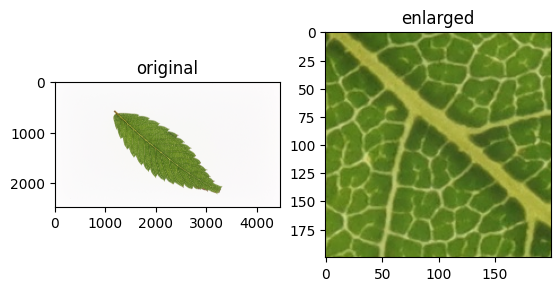

In [6]:
file_name = "Zelkova_serrata_0.jpg"
path = os.path.join(BASE_DIR, "data/interm/non-treated-dataset/", file_name)
orig_im = cv2.imread(path)[...,::-1]
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(orig_im)
plt.subplot(1,2,2)
plt.title("enlarged")
plt.imshow(orig_im[1000:1200, 1600:1800, :])
plt.show()

この画像から葉脈を抽出します。

## 推論

### 前処理
推論に入力するための画像を準備します。

今回使用するU-Netモデルは、以下の入出力形式を持つことに留意します。

- 入力：縦ｘ横が32の倍数であるRGB画像。（ただし、色合いはグレースケール）
- 出力：入力と縦ｘ横が同じ大きさのチャンネル数１の画像。

以下のコードでは、グレースケール変換するとともに、画像中の緑成分（葉領域）を検出し、それ以外のピクセル値を０に変換します。

In [7]:
def detect_green_color_region(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_min = np.array([30, 64, 0])
    hsv_max = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, hsv_min, hsv_max)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    return mask, masked_img

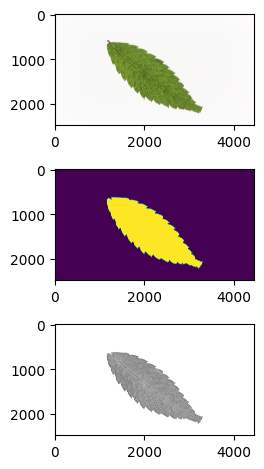

In [8]:
im = orig_im.copy()

contours, _ = cv2.findContours(
    detect_green_color_region(im)[0],
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
    )
max_contours = max(contours, key=lambda x: cv2.contourArea(x))
mask = cv2.drawContours(
    np.zeros_like(im[:,:,0]),
    [max_contours],
    -1,
    color=255,
    thickness=-1
    )
im = cv2.cvtColor(orig_im, cv2.COLOR_BGR2GRAY)
im = np.where(mask==255, 255-im, 255)
im = np.expand_dims(im, axis=-1)
im = np.repeat(im, 3, axis=-1)

plt.subplot(3,1,1)
plt.imshow(orig_im)
plt.subplot(3,1,2)
plt.imshow(mask)
plt.subplot(3,1,3)
plt.imshow(im)
plt.tight_layout()
plt.show()

推論対象の画像がモデルにとって大きすぎるため、画像を切り抜きます。さらにスライディングウィンドウを用いた分割推論を行うために、縦横それぞれが512ピクセルで割り切れるサイズへとパディングします。

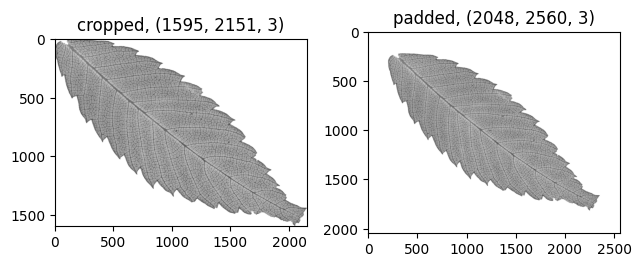

In [9]:
def pad_divisable(image, divisible_by=512):
    height, width = image.shape[:2]
    pad_height = (divisible_by - (height % divisible_by)) % divisible_by
    pad_width = (divisible_by - (width % divisible_by)) % divisible_by
    padded_image = cv2.copyMakeBorder(image, pad_height // 2, pad_height - pad_height // 2,
                                      pad_width // 2, pad_width - pad_width // 2, cv2.BORDER_CONSTANT, value=[255,255,255])
    return padded_image

# cropping
binary = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) < 255
lbl_image = label(binary)
prop = regionprops(lbl_image)[0]
bbox = prop.bbox
cropped = im[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# padding
padded = pad_divisable(cropped, divisible_by=512)

plt.subplot(1,2,1)
plt.title(f"cropped, {cropped.shape}")
plt.imshow(cropped)
plt.subplot(1,2,2)
plt.title(f"padded, {padded.shape}")
plt.imshow(padded)
plt.tight_layout()

スライディングウィンドウを用いて、パディング済みの入力画像を固定サイズのウィンドウに分割し、重複させながら全体をカバーし、予測を行います。各ウィンドウに対する予測を組み合わせ、平均化して最終予測を生成します。この方法は、モデルの処理能力を超える大きな画像やデータセットに適しています。

In [10]:
def infer(model, preprocessing, patch, device="cuda"):
    patch = preprocessing(image=patch)
    x_tensor = torch.from_numpy(patch['image']).to("cuda").unsqueeze(0)
    prediction = model.predict(x_tensor).squeeze().cpu().numpy()
    return prediction

In [11]:
window_size = 512
overlap = 32
stride = window_size - overlap

combined = np.zeros(padded.shape[:2], dtype=np.float32)
count = np.zeros(padded.shape[:2], dtype=np.float32) + 1e-6

for y in range(0, padded.shape[0], stride):
    for x in range(0, padded.shape[1], stride):
        patch = padded[y:y+window_size, x:x+window_size]
        _pred = infer(model, preprocessing, patch)
        combined[y:y+patch.shape[0], x:x+patch.shape[1]] += _pred
        count[y:y+patch.shape[0], x:x+patch.shape[1]] += 1

prediction =  combined/count

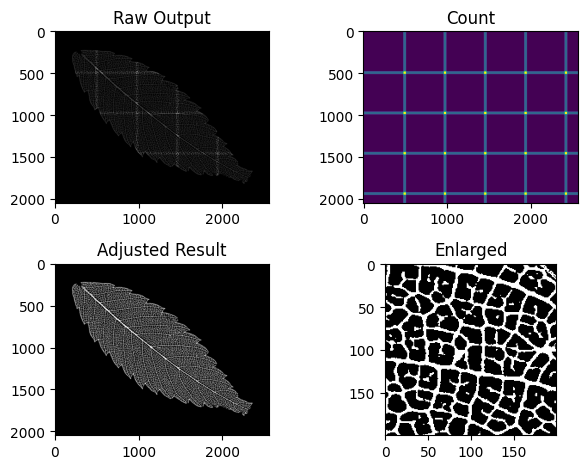

In [12]:
plt.subplot(2,2,1)
plt.title("Raw Output")
plt.imshow(combined, cmap="gray")
plt.subplot(2,2,2)
plt.title("Count")
plt.imshow(count)
plt.subplot(2,2,3)
plt.title("Adjusted Result")
plt.imshow(prediction,cmap="gray")
plt.subplot(2,2,4)
plt.title("Enlarged")
plt.imshow(prediction[1000:1200, 1600:1800]>0.4,cmap="gray")
plt.tight_layout()

## skeletonization

skeletonize(細線化/骨格抽出)します。

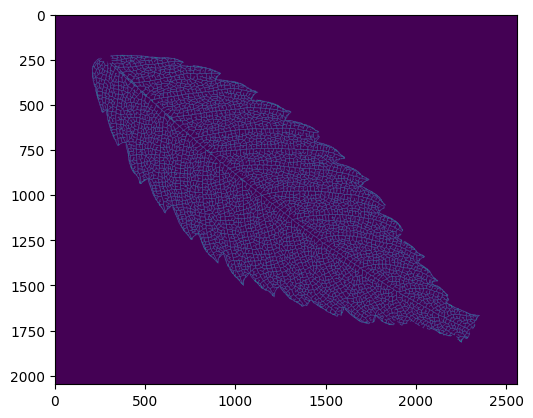

In [15]:
binary = prediction > 0.4
binary = binary.astype(np.uint8)
skel = skeletonize(binary)
plt.imshow(skel)
plt.show()

各ステップで画像がどのように変換されたか切り抜き画像で比較してみましょう。

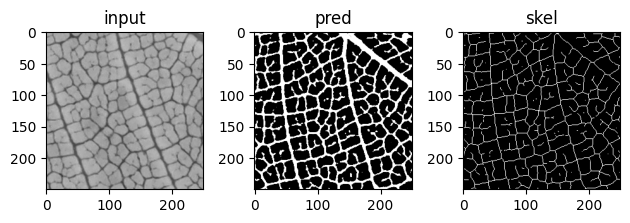

In [16]:
idxs = (1000, 1250, 1000,1250)

for i, (image, name) in enumerate(zip([cropped, prediction, skel],
                                      ["input", "pred", "skel"])):
    plt.subplot(1, 3, i+1)
    plt.title(name)
    plt.imshow(image[idxs[0]:idxs[1], idxs[2]:idxs[3]], cmap="gray")
plt.tight_layout()

## ネットワーク解析

In [17]:
from skan import Skeleton, summarize, draw

skanライブラリの可視化機能を使って解析対象画像の上にskeleton処理した結果を描画してみましょう。

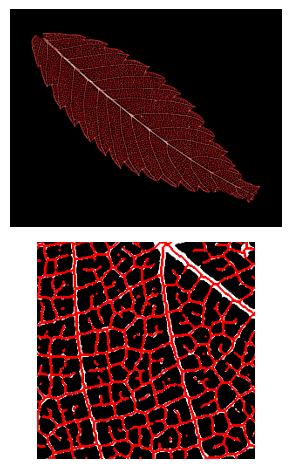

In [18]:
fig, ax = plt.subplots(2,1, tight_layout=True)
draw.overlay_skeleton_2d(prediction, skel, dilate=1, axes=ax[0])
draw.overlay_skeleton_2d(prediction[idxs[0]:idxs[1], idxs[2]:idxs[3]], skel[idxs[0]:idxs[1], idxs[2]:idxs[3]], dilate=1, axes=ax[1])
plt.show()

skelの機能を使ってネットワーク構造の解析を行います。検出された枝の特徴量情報がデータフレームに格納します。

In [ ]:
branch_data = summarize(Skeleton(skel))
branch_data.head()

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,10,39,4.828427,2,1.0,0.0,228,374,229,371,228,374,229,371,3.162278
1,0,10,19,9.000000,2,1.0,0.0,228,374,228,383,228,374,228,383,9.000000
2,0,10,92,2.000000,2,1.0,0.0,228,374,230,374,228,374,230,374,2.000000
3,0,19,20,1.000000,1,1.0,0.0,228,383,228,384,228,383,228,384,1.000000
4,0,19,93,2.000000,2,1.0,0.0,228,383,230,383,228,383,230,383,2.000000


上のデータフレームにおけるbranch-typeはそれぞれ、
1. endpoint-to-endpoint (isolated branch)
2. junction-to-endpoint
3. junction-to-junction
4. isolated cycle

を意味します。branch-typeと枝の長さ（branch-distance）との関係をヒストグラムで可視化してみましょう。

参考リンク：https://skeleton-analysis.org/stable/getting_started/getting_started.html

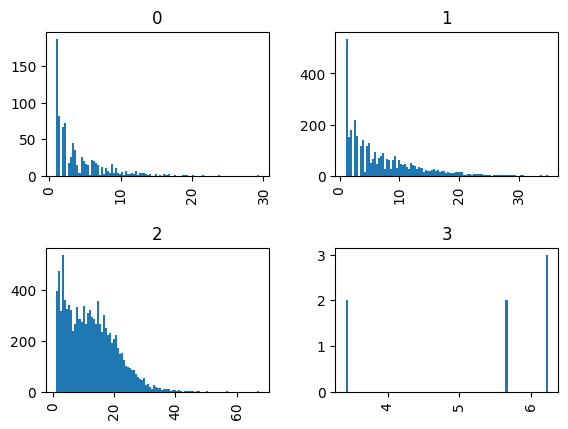

In [ ]:
branch_data.hist(column='branch-distance', by='branch-type', bins=100);

蛇足になりますが、枝の特徴量に応じて可視化の色合いを変えることもできます。

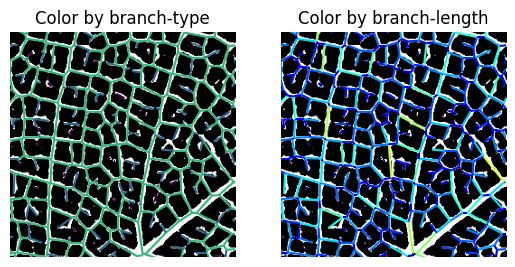

In [ ]:
fig, ax = plt.subplots(1,2)

draw.overlay_euclidean_skeleton_2d(prediction, branch_data,
                                   skeleton_color_source='branch-type',
                                   axes=ax[0])
ax[0].set_title("Color by branch-type")
ax[0].set_ylim([idxs[0],idxs[1]])
ax[0].set_xlim([idxs[2],idxs[3]])

draw.overlay_euclidean_skeleton_2d(prediction, branch_data,
                                   skeleton_color_source='branch-distance',
                                   skeleton_colormap='jet',
                                   axes=ax[1])
ax[1].set_title("Color by branch-length")
ax[1].set_ylim([idxs[0],idxs[1]])
ax[1].set_xlim([idxs[2],idxs[3]])

plt.show()

In this study, the following seven features were calculated for each node: the number of neighbors of a node, clustering coefficient of a node, average number of one-hop neighbors, average clustering coefficient of one-hop away neighbors for a node, number of edges in egonet (one-hop), number of outgoing edges from egonet (one-hop), and number of neighbors of egonet (one-hop).

In [ ]:
import networkx as nx
import numpy as np
from scipy.stats import skew, kurtosis

In [ ]:
# Initialize an undirected graph
G = nx.Graph()

# Add edges from the dataframe
for _, row in branch_data.iterrows():
    G.add_edge(row['node-id-src'], row['node-id-dst'])

# Calculate the specified features for each node
features = {
    'node_id': [],
    'degree': [],
    'clustering_coefficient': [],
    'neighbor_one_hop': [],
    'clustering_neighbor_one_hop': [],
    'edges_in_egonet_one_hop': [],
    'edges_outgoing_from_egonet_one_hop': [],
    'neighbor_of_egonet_one_hop': [],
}

for node in G.nodes:
    ego = nx.ego_graph(G, node, radius=1)
    neighbors_one_hop = list(ego.nodes)
    neighbors_one_hop.remove(node)  # Remove the node itself from its neighbors
    edges_in_egonet = ego.size()
    edges_outgoing_from_egonet = sum(deg for n, deg in G.degree(neighbors_one_hop)) - 2 * edges_in_egonet
    neighbors_of_egonet = len(nx.ego_graph(G, node, radius=2).nodes) - len(ego.nodes)

    features['node_id'].append(node)
    features['degree'].append(G.degree(node))
    features['clustering_coefficient'].append(nx.clustering(G, node))
    features['neighbor_one_hop'].append(len(neighbors_one_hop))
    features['clustering_neighbor_one_hop'].append(np.mean([nx.clustering(G, n) for n in neighbors_one_hop]) if neighbors_one_hop else 0)
    features['edges_in_egonet_one_hop'].append(edges_in_egonet)
    features['edges_outgoing_from_egonet_one_hop'].append(edges_outgoing_from_egonet)
    features['neighbor_of_egonet_one_hop'].append(neighbors_of_egonet)

# Convert to DataFrame for easy handling and exporting
features_df = pd.DataFrame(features)

features_df.head()

,node_id,degree,clustering_coefficient,neighbor_one_hop,clustering_neighbor_one_hop,edges_in_egonet_one_hop,edges_outgoing_from_egonet_one_hop,neighbor_of_egonet_one_hop
0,10.0,3,0.333333,3,0.222222,4,1,4
1,39.0,3,0.333333,3,0.333333,4,1,4
2,19.0,3,0.000000,3,0.111111,3,1,4
3,92.0,3,0.333333,3,0.222222,4,1,4
4,20.0,1,0.000000,1,0.000000,1,1,2


In [ ]:
# Calculate average, std, skewness, and kurtosis for each feature
feature_stats = {
    'feature': [],
    'average': [],
    'std': [],
    'skewness': [],
    'kurtosis': []
}

for col in features_df.columns[1:]:  # Skip the node_id column
    values = features_df[col]
    feature_stats['feature'].append(col)
    feature_stats['average'].append(values.mean())
    feature_stats['std'].append(values.std())
    feature_stats['skewness'].append(skew(values))
    feature_stats['kurtosis'].append(kurtosis(values))

feature_stats_df = pd.DataFrame(feature_stats)
feature_stats_df

,feature,average,std,skewness,kurtosis
0,degree,2.204778,0.971913,-0.385985,-1.770633
1,clustering_coefficient,0.007675,0.053406,7.747235,70.345947
2,neighbor_one_hop,2.203726,0.972134,-0.383765,-1.772413
3,clustering_neighbor_one_hop,0.008333,0.044820,6.429453,48.499507
4,edges_in_egonet_one_hop,2.227764,1.003915,-0.278743,-1.598885
5,edges_outgoing_from_egonet_one_hop,1.346905,1.438546,-0.322659,-0.739809
6,neighbor_of_egonet_one_hop,3.516677,2.113138,-0.164569,-1.252295
